In [32]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import numpy as np
import os
import random
import matplotlib.pyplot as plt

import importlib
import utils.ml_utils as ml_utils

## Set random seeds and make TF operation on GPU deterministic

In [33]:
# Make GPU use deterministic algorithms (see https://github.com/NVIDIA/tensorflow-determinism)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Seed value (can actually be different for each attribution step)
seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

## Base run

In [7]:
# Constants
IMG_SIZE = 128 # All images in the dataset will be resized to this size
BATCH_SIZE = 32 # Batch size

# Read training data
train, validation, test = ml_utils.load_batched_and_resized_dataset(
    dataset_name='cats_and_dogs',
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 2326
Class: 0 :::: Count: 1120 :::: Percentage: 48.15133276010318
Class: 1 :::: Count: 1206 :::: Percentage: 51.84866723989682

Test Data Summary
No. of examples: 2326
Class: 0 :::: Count: 1160 :::: Percentage: 49.871023215821154
Class: 1 :::: Count: 1166 :::: Percentage: 50.128976784178846


In [4]:
model = ml_utils.build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 4)       112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        4

In [5]:
# Start training
history = model.fit(
    train,
    epochs=10,
    validation_data=validation
)

Epoch 1/10
582/582 [==============================] - 53s 91ms/step - loss: 0.6918 - accuracy: 0.5399 - val_loss: 0.6909 - val_accuracy: 0.5215
Epoch 2/10
582/582 [==============================] - 9s 15ms/step - loss: 0.6874 - accuracy: 0.5794 - val_loss: 0.6815 - val_accuracy: 0.6006
Epoch 3/10
582/582 [==============================] - 9s 15ms/step - loss: 0.6772 - accuracy: 0.5996 - val_loss: 0.6647 - val_accuracy: 0.5967
Epoch 4/10
582/582 [==============================] - 9s 15ms/step - loss: 0.6640 - accuracy: 0.6069 - val_loss: 0.6516 - val_accuracy: 0.6285
Epoch 5/10
582/582 [==============================] - 9s 15ms/step - loss: 0.6521 - accuracy: 0.6239 - val_loss: 0.6347 - val_accuracy: 0.6492
Epoch 6/10
582/582 [==============================] - 9s 15ms/step - loss: 0.6395 - accuracy: 0.6375 - val_loss: 0.6217 - val_accuracy: 0.6595
Epoch 7/10
582/582 [==============================] - 9s 15ms/step - loss: 0.6256 - accuracy: 0.6553 - val_loss: 0.6070 - val_accuracy: 0.671

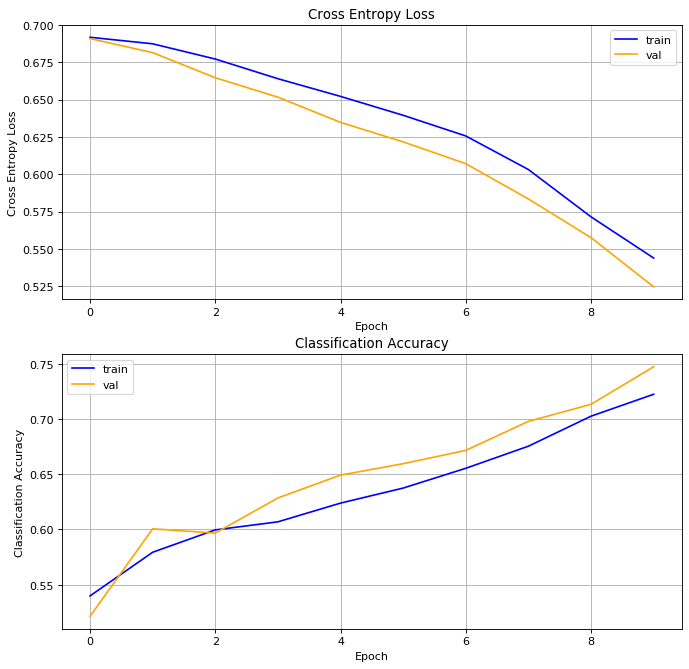

In [6]:
# Plot diagnostic learning curves
ml_utils.summarize_diagnostics(history)

## Identical runs

**tl;dr Runs are very close (<0.2% difference in val accuracy between runs). Difference is due to usage of GPU.**

First, we perform a sanity check to ensure that multiple identical runs give the same result. Unfortunately, identical runs give slightly varying results, despite using  I checked that initializations and training data orders are the same across runs. The problem seems to be related to the GPU, since when we use the CPU instead, identical runs give identical results.

In [31]:
initialization_weights = []

for i in range(5):    
    # Build and train model
    model = ml_utils.build_model()
    initialization_weights.append([w.value() for w in model.weights])
    history = model.fit(
        train,
        epochs=1,
        validation_data=validation
    )

582/582 [==============================] - 12s 21ms/step - loss: 0.6919 - accuracy: 0.5434 - val_loss: 0.6902 - val_accuracy: 0.5989


In [64]:
# Check that initialization weights are the same
from functools import reduce

weights_equal = True

#Iterate through iterations
for i in range(4):
    curr_weights = initialization_weights[i]
    next_weights = initialization_weights[i+1]

    # Iterate through layers
    for j in range(len(curr_weights)):
        weights_equal &= tf.math.reduce_all(tf.math.equal(curr_weights[j], next_weights[j]))
print("Weights equal = ", weights_equal)

Weights equal =  tf.Tensor(True, shape=(), dtype=bool)


In [48]:
# Try using CPU
for i in range(5):
    with tf.device('/cpu:0'):
        model = ml_utils.build_model()
        history = model.fit(
            train,
            epochs=1,
            validation_data=validation
        )

582/582 [==============================] - 160s 275ms/step - loss: 0.6919 - accuracy: 0.5438 - val_loss: 0.6902 - val_accuracy: 0.5985


In [61]:
final_weights = []

for i in range(5):
    model = keras.models.Sequential([
        keras.layers.Conv2D(
            input_shape=(IMG_SIZE,IMG_SIZE,3),
            filters=4,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
            kernel_initializer=keras.initializers.glorot_uniform(seed=0),
        ),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(
            input_shape=(IMG_SIZE,IMG_SIZE,3),
            filters=8,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
            kernel_initializer=keras.initializers.glorot_uniform(seed=0),
        ),
        keras.layers.MaxPooling2D(),
#         keras.layers.Conv2D(
#             filters=16,
#             kernel_size=3,
#             strides=1,
#             padding='same',
#             activation='relu',
#             kernel_initializer=keras.initializers.glorot_uniform(seed=0),
#         ),
#         keras.layers.MaxPooling2D(),
#         keras.layers.Conv2D(
#             filters=32,
#             kernel_size=3,
#             strides=1,
#             padding='same',
#             activation='relu',
#             kernel_initializer=keras.initializers.glorot_uniform(seed=0),
#         ),
#         keras.layers.MaxPooling2D(),
#         keras.layers.Conv2D(
#             filters=64,
#             kernel_size=3,
#             strides=1,
#             padding='same',
#             activation='relu',
#             kernel_initializer=keras.initializers.glorot_uniform(seed=0),
#         ),
#         keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=0)),
        keras.layers.Dense(256, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=0)),
        keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=0)),
    ])
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train,
        epochs=1,
        validation_data=validation
    )
    final_weights.append([w.value() for w in model.weights])

582/582 [==============================] - 10s 17ms/step - loss: 0.6809 - accuracy: 0.5685 - val_loss: 0.6584 - val_accuracy: 0.6096
